# Coronavirus and ERA-5 Temperature Analysis

## This notebook demonstrates:

1. Reading in COVID-19 data (global or US only, updated daily) as an xr.Dataset().

2. Matching state or country regions to shapes from an ERA-5 dataset based on string name value.

3. Aggregating data where necessary (e.g. combine all cities in a state to produce a single array per state, or combine all states in a country).

4. Calculating exponential growth rate of confirmed COVID-19 cases in each region by the formula:
$$ P(t) = A e^{k  t}$$
where *P* is the population at time *t*, *A* is the initial population value, and *k* is the growth rate.

5. Scatter plotting exponential growth rate compared to mean temperatures from the ERA-5 dataset.

Currently the notebook demonstrates steps 1, 2, and 3 for a combined global and US dataset. But then focuses on US states for steps 4 and 5.

## Possible improvements:

1. Adding exception cases for states or countries that could not be matched based on string value due to differing name conventions between the COVID-19 and ERA-5 datasets (e.g. Ivory Coast vs Cote d'Ivoire, US vs United States of America).

2. Currently mean ERA-5 temperature is used for the entire window of November 2019 to February 2020 for simplicity. Perhaps it would be better to compare to mean temperature values from only the window of COVID-19 growth for each region.

3. Including error bars on the temperature vs COVID-19 growth rate scatter plot.

4. Adding comparison for other climate variables such as humidity.

5. Currently the notebook only looks at confirmed cases. It may be interesting to look at recovered and fatal cases of COVID-19 as well.


In [1]:
import requests
from contextlib import closing
import csv
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import math as m

%matplotlib inline

# Read COVID19 data

In [2]:
covid_world_dict = {'url' : 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
    'city_i' : None,
    'state_i': 0, 
    'country_i' : 1,
    'time_i' : 4,
    'time_f' : -1,
    'cases_f' : None
            }
covid_US_dict = {'url' : 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',   
    'city_i' : 5,
    'state_i' : 6, 
    'country_i' : 7,
    'time_i' : 11,
    'time_f' : -1,
    'cases_f' : None
           }

In [3]:
def read_covid_data(covid_dict):
    '''
    Returns a COVID19 dataset from html

            Parameters:
                covid_dict (dict): dictionary of information necessary to read COVID19 url
                    and indices corresponding to state, country, and the first time value.
                    Accepts: covid_world_dict or covid_US_dict

            Returns:
                ds (xr.Dataset): covid19 datasest with era5 index attributes 
    '''
    with closing(requests.get(covid_dict['url'], stream=True)) as r:
        f = (line.decode('utf-8') for line in r.iter_lines())
        reader = csv.reader(f, delimiter=',')

        header = next(reader)
        time = pd.date_range(start=header[covid_dict['time_i']], end=header[covid_dict['time_f']])
        
        ds_dict = {} 
        for line in reader:
            city = line[covid_dict['city_i']] if covid_dict['city_i'] else []
            state = line[covid_dict['state_i']]
            country = line[covid_dict['country_i']]
            cases = [int(i) for i in line[covid_dict['time_i']:covid_dict['cases_f']]]
            
            if city:
                combined_name = (city + ', ' + state +', ' + country)
            elif state:
                combined_name = (state +', ' + country)
            else:
                combined_name = country

            da = xr.DataArray(cases, coords = [time], dims = ['time'], name = combined_name)
            da.attrs['city'] = city
            da.attrs['state'] = state
            da.attrs['country'] = country

            ds_dict[combined_name] = da.to_dict()
        ds = xr.Dataset.from_dict(ds_dict)
    return ds

In [5]:
ds_world = read_covid_data(covid_world_dict)
ds_US = read_covid_data(covid_US_dict)
ds = xr.merge([ds_world, ds_US])
#print(ds)

# Match to ERA5 shapes

In [6]:
era5_state_dict = {'file' : '../era5_ne_states.csv', 'name' : 'name_en', 'region_level' : 'state'}
era5_country_dict = {'file':'../era5_ne_countries.csv', 'name':'NAME_EN', 'region_level' : 'country'}

In [7]:
def match_covid2era5(ds, era5_dict):
    '''
    Returns a COVID19 dataset with region names and indices corresponding with shapes in an ERA5 file. 
    Returned dataset does not contain information from regions that did not match the ERA5 shapes by name.

            Parameters:
                ds (xr.Dataset): dataset of COVID19 data
                era5_dict (dict): dictionary of information necessary to read era5 file:
                    file location, name variable, and region level
                        Accepts: era5_state_dict or era5_country_dict

            Returns:
                ds_matched (xr.Dataset): covid19 datasest with era5 index attributes 
    '''
    region_level = era5_dict['region_level']
    era5 = pd.read_csv(era5_dict['file']).to_xarray()
    era5_names = list(era5[era5_dict['name']].values)

    region_dict = {}
    region_set = set()
    ds = ds.copy()
    for da in ds:
        region = ds[da].attrs[region_level]
        
        del ds[da].attrs['city']
        if region_level == 'country':
            del ds[da].attrs['state']
            
        if region not in region_set:
            if region in era5_names:
                index = era5_names.index(region)
                ds[da].attrs['index'] = index 
                    
                da_dict = ds[da].to_dict()
                da_dict['name'] = region
                region_dict[region] = da_dict

                region_set.add(region)
        else:
            da_dict = ds[da].to_dict()                    
            region_dict[region]['data'] = np.add(region_dict[region]['data'], da_dict['data'])  

    ds_matched = xr.Dataset.from_dict(region_dict)
    return ds_matched

In [8]:
ds_states = match_covid2era5(ds, era5_state_dict)
print(ds_states)
# some states were dropped

<xarray.Dataset>
Dimensions:                       (time: 82)
Dimensions without coordinates: time
Data variables:
    Australian Capital Territory  (time) int64 0 0 0 0 0 ... 99 100 103 103 103
    New South Wales               (time) int64 0 0 0 0 3 ... 2773 2822 2857 2857
    Northern Territory            (time) int64 0 0 0 0 0 0 ... 28 28 28 28 28 28
    Queensland                    (time) int64 0 0 0 0 0 ... 943 953 965 974 983
    South Australia               (time) int64 0 0 0 0 0 ... 415 420 428 429 429
    Tasmania                      (time) int64 0 0 0 0 0 ... 98 111 122 133 133
    Victoria                      (time) int64 0 0 0 0 1 ... 1228 1241 1265 1268
    Western Australia             (time) int64 0 0 0 0 0 ... 481 495 506 514 514
    Alberta                       (time) int64 0 0 0 0 0 ... 1423 1451 1567 1567
    British Columbia              (time) int64 0 0 0 0 0 ... 1336 1370 1445 1445
    Manitoba                      (time) int64 0 0 0 0 0 ... 217 221 230 243 

In [9]:
ds_countries = match_covid2era5(ds, era5_country_dict)
print(ds_countries)
# some countries were dropped

<xarray.Dataset>
Dimensions:                   (time: 82)
Dimensions without coordinates: time
Data variables:
    Afghanistan               (time) int64 0 0 0 0 0 0 ... 444 484 521 555 607
    Albania                   (time) int64 0 0 0 0 0 0 ... 400 409 416 433 446
    Algeria                   (time) int64 0 0 0 0 0 ... 1666 1761 1825 1914
    Angola                    (time) int64 0 0 0 0 0 0 0 ... 17 19 19 19 19 19
    Argentina                 (time) int64 0 0 0 0 0 ... 1795 1975 1975 2142
    Armenia                   (time) int64 0 0 0 0 0 0 ... 881 921 937 967 1013
    Australia                 (time) int64 0 0 0 0 4 ... 6108 6215 6303 6315
    Austria                   (time) int64 0 0 0 0 0 ... 13244 13555 13806 13945
    Azerbaijan                (time) int64 0 0 0 0 0 0 ... 822 926 991 1058 1098
    Bangladesh                (time) int64 0 0 0 0 0 0 ... 218 330 424 482 621
    Belarus                   (time) int64 0 0 0 0 0 ... 1486 1981 2226 2578
    Belgium            

# Focus on the US

In [10]:
#ds_US

In [11]:
ds_US_states = match_covid2era5(ds_US, era5_state_dict)
#print(ds_US_states)

## Calculate Growth Rate in New York

<xarray.DataArray 'New York' (time: 82)>
array([     0,      0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      1,      2,     11,     23,     31,
           76,    106,    142,    150,    220,    327,    421,    613,    615,
          967,   1578,   3038,   5704,   8403,  11727,  15800,  20884,  25681,
        30841,  37877,  44876,  52410,  59648,  66663,  75833,  83948,  92506,
       102987, 113833, 123160, 131815, 139875, 151061, 161779, 172348, 181026,
       189033])
Dimensions without coordinates: time
Attributes:
    state:    New York
    country:  US
    index:    1307


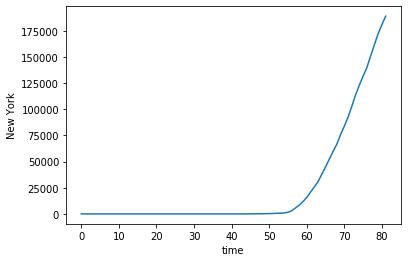

In [12]:
print(ds_US_states['New York'])
ds_US_states['New York'].plot()

In [13]:
def calc_growth_rate(cases):
    '''
    Calculates the exponential growth rate from first incidence of COVID19 to last recorded value
    Based on the formula:
        P(t) = A exp(k * t)
    Where P is the population at time t, A is the initial population value, and k is the growth rate.

            Parameters:
                total_cases (list): cumulative list of total cases

            Returns:
                k (float): calculated growth rate
    '''     
    i_0 = np.nonzero(cases)[0][0]
    
    P = cases[-1]
    A = cases[i_0]
    t = len(cases) - i_0 - 1 

    k = m.log(P / A) / t
    return k

In [14]:
k = calc_growth_rate(ds_US_states['New York'].values)
print(k)

0.29633358248719566


## Calculating Case Doubling Time

$$ T_d = (t_2 - t_1) * \frac{ln(2)}{ln(\frac{q_2}{q_1})}$$
where *T_d* is the case doubling time, *t* is time, and *q* is the growing quantity, assuming a constant growth rate in %.



In [15]:
def calc_doubling_time(cases):
    '''
    Calculates the exponential growth rate from first incidence of COVID19 to last recorded value
    Based on the formula:
        T_d = (t_2 - t_1) * ln(2) / ln(q_2 / q_1)

    Where *T_d* is the case doubling time, *t* is time, and *q* is the growing quantity, assuming a constant growth rate in %.

            Parameters:
                total_cases (list): cumulative list of total cases

            Returns:
                k (float): calculated growth rate
    '''     
    i_0 = np.nonzero(cases)[0][0]
    
    q_1 = cases[i_0]
    q_2 = cases[-1]
    delta_t = len(cases) - i_0 - 1 

    t_doubling = delta_t * np.log(2) / np.log(q_2 / q_1)
    return t_doubling

In [16]:
t_doubling = calc_doubling_time(ds_US_states['New York'].values)
print(t_doubling)

2.339077382800161


## Calculate Growth Rate in All States

In [14]:
ds_US_k = ds_US_states.copy()
for state in ds_US_states:
    if ds_US_states[state].values[-1] != 0:
        k = calc_growth_rate(ds_US_states[state].values)
        ds_US_k[state].attrs['growth_rate'] = k
    else:
        del ds_US_k[state]
        print('safe')
        
print(ds_US_k['Washington'])

safe
<xarray.DataArray 'Washington' (time: 69)>
array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    7,   11,   18,   27,   39,   70,   78,  102,  122,  122,
        167,  282,  442,  568,  642,  603,  779,  955, 1022, 1374, 1524, 1793,
       1997, 2221, 2328, 2591, 3207, 3477, 4030, 4465, 4923])
Dimensions without coordinates: time
Attributes:
    state:        Washington
    country:      US
    index:        1293
    growth_rate:  0.1250246085258559


## Compare to ERA5 temperature values

In [15]:
era5_dict = era5_state_dict
era5 = pd.read_csv(era5_dict['file']).to_xarray()

In [16]:
temps = [era5['2019-11'].values, era5['2019-12'].values, era5['2020-01'].values, era5['2020-02'].values]
mean_temps = np.mean(temps, axis = 0)

In [17]:
for state in ds_US_k:
    ds_US_k[state].attrs['mean_temp'] = mean_temps[ds_US_k[state].attrs['index']]
ds_US_k['Washington']

<xarray.DataArray 'Washington' (time: 69)>
array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    7,   11,   18,   27,   39,   70,   78,  102,  122,  122,
        167,  282,  442,  568,  642,  603,  779,  955, 1022, 1374, 1524, 1793,
       1997, 2221, 2328, 2591, 3207, 3477, 4030, 4465, 4923])
Dimensions without coordinates: time
Attributes:
    state:        Washington
    country:      US
    index:        1293
    growth_rate:  0.1250246085258559
    mean_temp:    2.3008194

In [18]:
growth_rates = []
mean_temps = []

for state in ds_US_k:
    growth_rates.append(ds_US_k[state].attrs['growth_rate'])
    mean_temps.append(ds_US_k[state].attrs['mean_temp'])

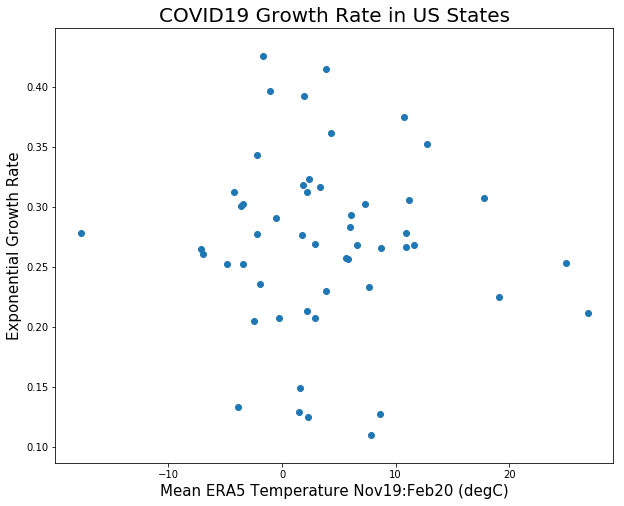

In [19]:
plt.figure(figsize=(10,8))
plt.scatter(mean_temps, growth_rates)
plt.title('COVID19 Growth Rate in US States', fontsize=20)
plt.xlabel('Mean ERA5 Temperature Nov19:Feb20 (degC)', fontsize=15)
plt.ylabel('Exponential Growth Rate', fontsize=15);